# **Ouroboros fMRI: Predicting human brain activity with machine learning models**

#### Version: 10th March 2021

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

The first version of this project (17th February 2021) was presented as a Capstone Project for the COS in Applied Data Science: Machine Learning of the EPFL Extension School (https://www.extensionschool.ch/).

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

***03: Neural Networks***

*04: Regression*

*05: Results*

*06: Complements*

==============================================================================================

### Notebook 03

# **Neural Networks**

## **1. Parameters and functions**

In this Notebook, we will run **different types of neural networks**, but some parameters will be common between all models. First, the **train-validation split** will always be defined as 80%-20%, i.e. the same proportions as in the cross-validated runs from the previous Notebook. Since we have 120 elements in the train+valid dataset, we will obtain a split of 96-24 elements. Second, the **batch size** will always be defined as 96, which is the length of the train sets obtained after the splitting. Since our dataset contains a limited number of elements, it does not seem necessary to divide it further into batches. 

Neural networks are stochastic by nature, and show a **certain variability** each time they are run. In our case, this variability can be significant: since we have only 36 elements in the test set, the correct or incorrect classification of a few of them can have a certain effect on the percentage of accuracy. But like in the previous Notebook, we are mostly interested in comparing the accuracy of the models to the baseline of 33%. 

In the following cells, we define a series of functions that will be helpful throughout the Notebook to **display the results from our neural networks with graphs**, and to compute **confusion matrixes** to visualize the accuracy of our predictions. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [2]:
# Define batch size and validation split. 
batch_size = 96
validation_split = 0.2

In [3]:
# Define a function to plot the results of the neural network training. 
def neural_network_graph(history):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

    # Plot loss values. 
    axes[0].plot(history.history['loss'], label = 'train loss', color = 'blue')
    axes[0].plot(history.history['val_loss'], label = 'val loss', color = 'green')
    axes[0].set_title('Validation loss {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_loss'][-3:]) # Take the mean of the last three values. 
    ))
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss value')
    axes[0].legend()

    # Plot accuracy values. 
    axes[1].plot(history.history['acc'], label = 'train acc', color = 'blue')
    axes[1].plot(history.history['val_acc'], label = 'val acc', color = 'green')
    axes[1].set_title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_acc'][-3:]) # Take the mean of the last three values. 
    ))
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend();

In [4]:
# Define a function to plot the results of the convolutional neural network training. 
def convolutional_neural_network_graph(neurological_axis):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
    convnet_results = eval('convnet_results_' + neurological_axis)
    convnet_non_zeros = eval('convnet_non_zeros_' + neurological_axis)
    
    # Normalize and reindex the number of non-zero values. 
    convnet_non_zeros = pd.Series(convnet_non_zeros / np.max(convnet_non_zeros))
    convnet_non_zeros.index = convnet_results.index

    # Plot test accuracy and non-zero values. 
    axes[0].plot(convnet_results.test_accuracy_convnet, color = 'blue')
    axes[0].set_xlabel('Sections through the ' + neurological_axis + ' view')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy through the ' + neurological_axis + ' view')
    axes[1].plot(convnet_non_zeros, '--', color = 'purple')
    axes[1].set_xlabel('Sections through the ' + neurological_axis + ' view')
    axes[1].set_ylabel('Non-zero values')
    axes[1].set_title('Non-zero values through the ' + neurological_axis + ' view');

In [5]:
# Define a function to generate a Scikit-learn confusion matrix. 
def scikit_learn_confusion_matrix(y_te, y_pred):
    # Compute the confusion matrix. 
    labels = ['good', 'neutral', 'bad']
    matrix = confusion_matrix(
        y_true = y_te,
        y_pred = y_pred, 
        labels = labels
    )

    # Return confusion matrix as a DataFrame. 
    matrix_df = pd.DataFrame(data = matrix, columns = labels, index = labels)
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df

In [6]:
# Define a function to generate a custom confusion matrix. 
def custom_confusion_matrix(y_te, y_pred):
    # Compute the confusion matrix. 
    pred_comparison = pd.DataFrame([y_te, y_pred], index = ['y_te', 'y_pred']).T
    labels = ['good', 'neutral', 'bad']
    matrix_df = pd.DataFrame()
    for y_te_value in labels:
        for y_pred_value in labels:
            matrix_df.loc[y_te_value, y_pred_value] = np.sum((pred_comparison.y_te == y_te_value) & 
                                                             (pred_comparison.y_pred == y_pred_value))

    # Return confusion matrix as a DataFrame. 
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df.astype(int)

## **2. Data import**

In [7]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [8]:
# Select rescale mode. 
# 1: original data | 2, 3, 4: voxel size rescaled by a factor 2, 3 or 4. 
rescale_mode = 1

In [9]:
# Load data. 
with np.load(preprocessed_data_path + 'datasets_for_machine_learning.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
rescale_modes_list = ['', '_r2', '_r3', '_r4']
    
# Features of the train+valid dataset. 
X = data_dict['features_preprocessed' + rescale_modes_list[rescale_mode - 1] + '_tr']
X_convnet = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_tr']

# Features of the test dataset. 
X_te = data_dict['features_preprocessed' + rescale_modes_list[rescale_mode - 1] + '_te']
X_convnet_te = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_te']

# Target variables. 
y = data_dict['target_tr']
y_te = data_dict['target_te']

In [10]:
# Display the size of the arrays. 
print('X:           ', X.shape)
print('X_convnet:   ', X_convnet.shape)
print('X_te:        ', X_te.shape)
print('X_convnet_te:', X_convnet_te.shape)
print('y:           ', y.shape)
print('y_te:        ', y_te.shape)

X:            (120, 256007)
X_convnet:    (120, 91, 109, 91)
X_te:         (36, 256007)
X_convnet_te: (36, 91, 109, 91)
y:            (120,)
y_te:         (36,)


## **3. Dense neural network: 1-layer**

In the following cells, we **run and compute the predictions from a 1-layer neural network model**. 

In [11]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

In [12]:
# Rescale features variables. 
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (120, 256007)
Test: (36, 256007)


In [13]:
# Encode target variable. 
y_encoded = pd.get_dummies(y)
y_te_encoded = pd.get_dummies(y_te)

In [14]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array(['bad', 'good', 'neutral'], dtype='<U7')

In [15]:
# Create model. 
model_dense1 = Sequential()

# Output layer. 
model_dense1.add(Dense(
    units = 3, activation = activations.softmax, input_dim = X_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 768024    
Total params: 768,024
Trainable params: 768,024
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Security check: verify that the number of parameters corresponds to what is expected, 
# i.e. the number of features multiplied by the number of target classes, plus the biases for each output neuron. 
model_dense1.count_params() == ((X_standardized.shape[1] * 3) + 3)

True

In [17]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense1 = model_dense1.fit(
    x = X_standardized, y = y_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 1s 6ms/step - loss: 1.4602 - acc: 0.3542 - val_loss: 9.9689 - val_acc: 0.3333
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 8.2299 - acc: 0.4688 - val_loss: 9.6627 - val_acc: 0.3750
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 8.7071 - acc: 0.4375 - val_loss: 9.6422 - val_acc: 0.3750
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 8.2765 - acc: 0.4688 - val_loss: 9.4167 - val_acc: 0.3750
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 8.6318 - acc: 0.4583 - val_loss: 9.2910 - val_acc: 0.3750
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 8.5548 - acc: 0.4583 - val_loss: 9.2380 - val_acc: 0.3750
Epoch 7/100
96/96 [==============================] - 0s 1ms/step - loss: 8.5126 - acc: 0.4583 - val_loss: 9.2721 - val_acc: 0.3750
Epoch 8/100
96/96 [====================

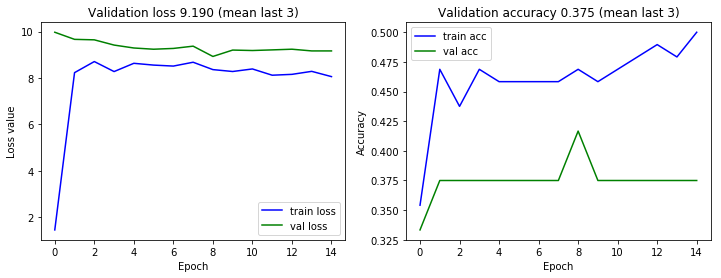

In [18]:
# Display the results. 
neural_network_graph(history_dense1)

In [19]:
# Evaluate test score. 
(test_loss, test_score_dense1) = model_dense1.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense1))

36/36 [==============================] - 0s 1ms/step
Test loss: 3.07
Test accuracy: 69.44%


In [20]:
# Compute and display the predictions of the neural network. 
y_pred_dense1 = encoding_order[model_dense1.predict_classes(X_te_standardized)]
y_pred_dense1

array(['bad', 'bad', 'neutral', 'bad', 'bad', 'bad', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'good',
       'neutral', 'neutral', 'bad', 'bad', 'good', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'neutral', 'bad', 'neutral', 'neutral',
       'bad', 'bad', 'neutral', 'good', 'neutral', 'neutral', 'bad',
       'bad'], dtype='<U7')

In [21]:
# Security check: compute the accuracy from these predictions. 
test_score_dense1_from_pred = np.sum(y_pred_dense1 == y_te) / len(y_te)
test_score_dense1_from_pred

0.6944444444444444

In [22]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense1_from_pred, 4) == np.round(test_score_dense1, 4)

True

In [23]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense1 = scikit_learn_confusion_matrix(y_te, y_pred_dense1)
confusion_matrix_dense1

Predictions,good,neutral,bad
True class,,,
good,4,5,3
neutral,0,11,1
bad,0,2,10


In [24]:
# Security check: display a custom confusion matrix. 
custom_confusion_matrix_dense1 = custom_confusion_matrix(y_te, y_pred_dense1)
custom_confusion_matrix_dense1

Predictions,good,neutral,bad
True class,,,
good,4,5,3
neutral,0,11,1
bad,0,2,10


In [25]:
# Verify if the two confusion matrixes are equal. 
confusion_matrix_dense1.equals(custom_confusion_matrix_dense1)

True

**Result:** The 1-layer neural network model performs better than the baseline of 33%. 

## **4. Dense neural network: 2-layer**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. We add both a dropout and a L2 regularization to the hidden layer. The number of units in the hidden layer was defined by trial and error. For the dropout and the regularization parameters, we simply use values that seem widely used by the machine learning community. 

In [26]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [27]:
# Create model. 
model_dense2 = Sequential()

# Hidden layer. 
model_dense2.add(Dense(
    units = 256, activation = activations.relu, input_dim = X_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense2.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense2.add(Dense(
    units = 3, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               65538048  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 65,538,819
Trainable params: 65,538,819
Non-trainable params: 0
_________________________________________________________________


In [28]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense2 = model_dense2.fit(
    x = X_standardized, y = y_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 6s 58ms/step - loss: 6.4334 - acc: 0.4479 - val_loss: 10.4875 - val_acc: 0.3333
Epoch 2/100
96/96 [==============================] - 1s 7ms/step - loss: 9.9695 - acc: 0.4688 - val_loss: 9.6232 - val_acc: 0.5417
Epoch 3/100
96/96 [==============================] - 1s 8ms/step - loss: 10.3028 - acc: 0.4688 - val_loss: 11.6879 - val_acc: 0.5000
Epoch 4/100
96/96 [==============================] - 1s 7ms/step - loss: 10.0800 - acc: 0.5312 - val_loss: 11.0214 - val_acc: 0.4583
Epoch 5/100
96/96 [==============================] - 1s 6ms/step - loss: 9.9034 - acc: 0.5625 - val_loss: 11.5326 - val_acc: 0.5000
Epoch 6/100
96/96 [==============================] - 1s 8ms/step - loss: 9.7203 - acc: 0.5729 - val_loss: 11.1612 - val_acc: 0.5000
Epoch 7/100
96/96 [==============================] - 1s 7ms/step - loss: 9.0443 - acc: 0.6250 - val_loss: 11.0749 - val_acc: 0.5417
Epoch 8/100
96/96 [===========

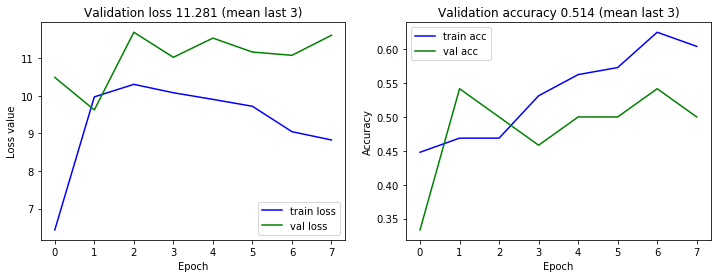

In [29]:
# Display the results. 
neural_network_graph(history_dense2)

In [30]:
# Evaluate test score. 
(test_loss, test_score_dense2) = model_dense2.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense2))

36/36 [==============================] - 0s 3ms/step
Test loss: 7.40
Test accuracy: 66.67%


In [31]:
# Compute and display the predictions of the neural network. 
y_pred_dense2 = encoding_order[model_dense2.predict_classes(X_te_standardized)]
y_pred_dense2

array(['good', 'good', 'neutral', 'neutral', 'bad', 'bad', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'bad', 'bad', 'good', 'good',
       'neutral', 'neutral', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad',
       'bad', 'bad', 'neutral', 'good', 'neutral', 'neutral', 'bad',
       'good'], dtype='<U7')

In [32]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense2 = scikit_learn_confusion_matrix(y_te, y_pred_dense2)
confusion_matrix_dense2

Predictions,good,neutral,bad
True class,,,
good,5,5,2
neutral,0,10,2
bad,1,2,9


**Result:** The 2-layer neural network model performs better than the baseline of 33%. 

## **5. Convolutional neural network**

In the following cells, we **run and compute the predictions from a convolutional neural network model (ConvNet)**, but the approach here is quite experimental. The main challenge for using ConvNets is that the statistical maps are 3D images, and not 2D images. In our ConvNets, kernels are tridimensional by nature, but their third dimension should normally be used to store the several layers of information of a pixel, typically the red, green and blue channels of a RGB image. We could use this third dimension to represent the third dimension of our statistical maps, but in that case the kernels would be at least 91 voxels deep, which is a lot. And indeed, preliminary tests were performed with this method, and the test accuracy stayed at 33%, which is the level of chance. This seemed to confirm that this method does not exploit accurately the information of a 3D brain map. A reasonable explanation may be that such kernels actually flatten the information along the third dimension, which is not optimal since in a 3D brain map, the signal is spatially distributed in such a way that all three dimensions are important. 

Here, we will use a different method, and approach this problem with a **grid search strategy**, by taking advantage of the fact that the statistical maps are normalized using the MNI template, which means that a certain section of a map, let's say [0, :, :], is comparable to a similar section of another map. In other words, while fitting directly a ConvNet on the 3D images appears to be difficult, it is easier to fit a series of ConvNets, each one on a specific section. The first ConvNet will be fitted on the section [0, :, :] of all the images, the second on the section [1, :, :], etc. In fact, we can slice a 3D brain map through three different axes, corresponding to the three neurological views. Therefore, we could actually fit a series of ConvNets on every [x, :, :] section corresponding to the **sagittal view**, a second series on every [:, y, :] section corresponding to the **coronal view**, and a third series on every [:, :, z] section corresponding to the **axial view**. 

Therefore, **instead of running a single ConvNet on 3D images, we will run a maximum of 291 (91 + 109 + 91) ConvNets on 2D images**. Once every ConvNet is run, we expect the distribution of test scores to be logical according to our knowledge of a 3D brain map. In particular, we expect that for the peripheral sections, which are mostly empty, the ConvNets should stay at an accuracy level corresponding to the level of chance, while in the central sections, which have much more information, the accuracy of the ConvNets should increase. Since running 291 ConvNets is computationally heavy, we will actually choose only a selection of sections through each neurological view. 

Of course, once the grid search is run, we will end up with a series of fitted models. Each model will provide a different classification of the test set, and **the final step will be to combine these predictions**. We will use a straightforward approach: for every statistical map of the test set, we will simply sum up the probabilities predicted by all the ConvNets, and select the target value with the highest sum. While simple, this approach seems quite robust. For the sections containing little information, typically the ones corresponding to peripheral images, the probabilities predicted by the ConvNets should be both similar and close to the level of chance, i.e. [0.33, 0.33, 0.33] for the three target values. Overall, these sections will have no effect towards one or another of these values. On the other hand, for the sections containing more information, the probabilities should be more oriented, for example [0.8, 0.05, 0.15], so these sections should actually contribute to the final selection of the most probable target value. 

As a final note, we should mention that the current version of Keras includes a tf.keras.layers.Conv3D module, corresponding to a **3D convolutional layer**. We will not use this module here, mostly because sliding kernels on the whole volume of our brain maps could be computationally heavy. While our method is arguably more complex, running a series of 2D convolutional layers will allow us to control the number of sections to include. Moreover, differentiating the predictions through the three neurological views, while also showing the distribution of non-zero values through these views, could give interesting insights into our data. 

In [33]:
def define_convnet(input_image_shape):
    # Define the convolutional network. 
    model_convnet = keras.Sequential()
    model_convnet.add(keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 2,
                                  activation = 'relu', input_shape = input_image_shape))
    model_convnet.add(keras.layers.MaxPool2D(pool_size = 2))
    model_convnet.add(keras.layers.Flatten())
    model_convnet.add(keras.layers.Dense(units = 3, activation = 'softmax'))
    
    # Define loss function, optimizer and metrics to track during training. 
    model_convnet.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    return model_convnet

In [34]:
# Define the number of sections to explore. 
step = 3
sagittal_sections = list(range(0, X_convnet.shape[1], step))
coronal_sections = list(range(0, X_convnet.shape[2], step))
axial_sections = list(range(0, X_convnet.shape[3], step))

# Prepare empty data structures to save the results from the grid search. 
convnet_results_sagittal = pd.DataFrame()
convnet_results_coronal = pd.DataFrame()
convnet_results_axial = pd.DataFrame()
convnet_predictions_sagittal = np.zeros((len(sagittal_sections), 36, 3))
convnet_predictions_coronal = np.zeros((len(coronal_sections), 36, 3))
convnet_predictions_axial = np.zeros((len(axial_sections), 36, 3))
convnet_non_zeros_sagittal = np.zeros(len(sagittal_sections))
convnet_non_zeros_coronal = np.zeros(len(coronal_sections))
convnet_non_zeros_axial = np.zeros(len(axial_sections))

# Define early stopping when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

### 5.1 Convolutional neural networks through sagittal view

In [35]:
# Run convolutional networks through sagittal sections. 
step_counter = 0

for sagittal_section in sagittal_sections:
    # Information. 
    print('Starting step:', step_counter, '/', str(len(sagittal_sections)))
    
    # Define the shape of the input image. 
    input_image_shape = (X_convnet.shape[2], X_convnet.shape[3], 1)
    
    # Define the convolutional network. 
    model_convnet = define_convnet(input_image_shape)

    # Fit model. 
    history_convnet = model_convnet.fit(
        x = X_convnet[:, sagittal_section, :, :, np.newaxis], 
        y = y_encoded,
        validation_split = validation_split, batch_size = batch_size, epochs = 100, shuffle = True, callbacks = [early_stopping], verbose = 0)
    
    # Evaluate test score and predict targets for the test set. 
    (test_loss_convnet, test_accuracy_convnet) = model_convnet.evaluate(X_convnet_te[:, sagittal_section, :, :, np.newaxis], 
                                                                        y_te_encoded, batch_size = batch_size, verbose = 0)
    test_predictions = model_convnet.predict(X_convnet_te[:, sagittal_section, :, :, np.newaxis], verbose = 0)
    
    # Save the results. 
    convnet_results_sagittal.loc[sagittal_section, 'test_loss_convnet'] = test_loss_convnet
    convnet_results_sagittal.loc[sagittal_section, 'test_accuracy_convnet'] = test_accuracy_convnet
    convnet_predictions_sagittal[step_counter, :, :] = test_predictions
    
    # Save the number of non-zero values in this section. 
    convnet_non_zeros_sagittal[step_counter] = np.sum(np.sum(X_convnet_te[:, sagittal_section, :, :], axis = 0) != 0)
    
    # Increment the section counter. 
    step_counter += 1

Starting step: 0 / 31
Starting step: 1 / 31
Starting step: 2 / 31
Starting step: 3 / 31
Starting step: 4 / 31
Starting step: 5 / 31
Starting step: 6 / 31
Starting step: 7 / 31
Starting step: 8 / 31
Starting step: 9 / 31
Starting step: 10 / 31
Starting step: 11 / 31
Starting step: 12 / 31
Starting step: 13 / 31
Starting step: 14 / 31
Starting step: 15 / 31
Starting step: 16 / 31
Starting step: 17 / 31
Starting step: 18 / 31
Starting step: 19 / 31
Starting step: 20 / 31
Starting step: 21 / 31
Starting step: 22 / 31
Starting step: 23 / 31
Starting step: 24 / 31
Starting step: 25 / 31
Starting step: 26 / 31
Starting step: 27 / 31
Starting step: 28 / 31
Starting step: 29 / 31
Starting step: 30 / 31


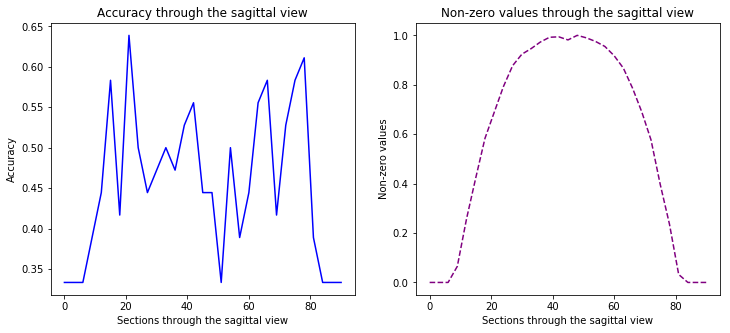

In [36]:
# Display the results as a graph. 
convolutional_neural_network_graph('sagittal')

### 5.2 Convolutional neural networks through coronal view

In [37]:
# Run convolutional networks through coronal sections. 
step_counter = 0

for coronal_section in coronal_sections:
    # Information. 
    print('Starting step:', step_counter, '/', str(len(coronal_sections)))
    
    # Define the shape of the input image. 
    input_image_shape = (X_convnet.shape[1], X_convnet.shape[3], 1)
    
    # Define the convolutional network. 
    model_convnet = define_convnet(input_image_shape)

    # Fit model. 
    history_convnet = model_convnet.fit(
        x = X_convnet[:, :, coronal_section, :, np.newaxis], 
        y = y_encoded,
        validation_split = validation_split, batch_size = batch_size, epochs = 100, shuffle = True, callbacks = [early_stopping], verbose = 0)
    
    # Evaluate test score and predict targets for the test set. 
    (test_loss_convnet, test_accuracy_convnet) = model_convnet.evaluate(X_convnet_te[:, :, coronal_section, :, np.newaxis], 
                                                                        y_te_encoded, batch_size = batch_size, verbose = 0)
    test_predictions = model_convnet.predict(X_convnet_te[:, :, coronal_section, :, np.newaxis], verbose = 0)
    
    # Save the results. 
    convnet_results_coronal.loc[coronal_section, 'test_loss_convnet'] = test_loss_convnet
    convnet_results_coronal.loc[coronal_section, 'test_accuracy_convnet'] = test_accuracy_convnet
    convnet_predictions_coronal[step_counter, :, :] = test_predictions
    
    # Save the number of non-zero values in this section. 
    convnet_non_zeros_coronal[step_counter] = np.sum(np.sum(X_convnet_te[:, :, coronal_section, :], axis = 0) != 0)
    
    # Increment the section counter. 
    step_counter += 1

Starting step: 0 / 37
Starting step: 1 / 37
Starting step: 2 / 37
Starting step: 3 / 37
Starting step: 4 / 37
Starting step: 5 / 37
Starting step: 6 / 37
Starting step: 7 / 37
Starting step: 8 / 37
Starting step: 9 / 37
Starting step: 10 / 37
Starting step: 11 / 37
Starting step: 12 / 37
Starting step: 13 / 37
Starting step: 14 / 37
Starting step: 15 / 37
Starting step: 16 / 37
Starting step: 17 / 37
Starting step: 18 / 37
Starting step: 19 / 37
Starting step: 20 / 37
Starting step: 21 / 37
Starting step: 22 / 37
Starting step: 23 / 37
Starting step: 24 / 37
Starting step: 25 / 37
Starting step: 26 / 37
Starting step: 27 / 37
Starting step: 28 / 37
Starting step: 29 / 37
Starting step: 30 / 37
Starting step: 31 / 37
Starting step: 32 / 37
Starting step: 33 / 37
Starting step: 34 / 37
Starting step: 35 / 37
Starting step: 36 / 37


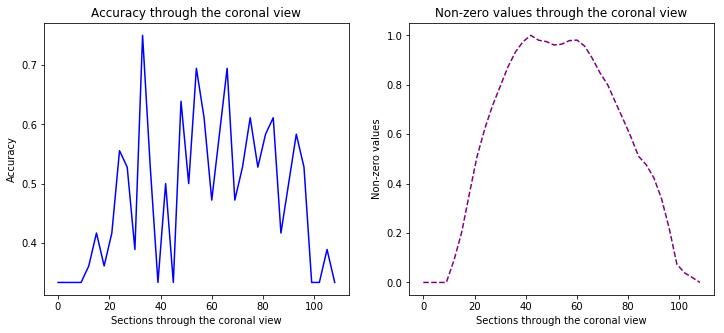

In [38]:
# Display the results as a graph. 
convolutional_neural_network_graph('coronal')

### 5.3 Convolutional neural networks through axial view

In [39]:
# Run convolutional networks through axial sections. 
step_counter = 0

for axial_section in axial_sections:
    # Information. 
    print('Starting step:', step_counter, '/', str(len(axial_sections)))
    
    # Define the shape of the input image. 
    input_image_shape = (X_convnet.shape[1], X_convnet.shape[2], 1)
    
    # Define the convolutional network. 
    model_convnet = define_convnet(input_image_shape)

    # Fit model. 
    history_convnet = model_convnet.fit(
        x = X_convnet[:, :, :, axial_section, np.newaxis], 
        y = y_encoded,
        validation_split = validation_split, batch_size = batch_size, epochs = 100, shuffle = True, callbacks = [early_stopping], verbose = 0)
    
    # Evaluate test score and predict targets for the test set. 
    (test_loss_convnet, test_accuracy_convnet) = model_convnet.evaluate(X_convnet_te[:, :, :, axial_section, np.newaxis], 
                                                                        y_te_encoded, batch_size = batch_size, verbose = 0)
    test_predictions = model_convnet.predict(X_convnet_te[:, :, :, axial_section, np.newaxis], verbose = 0)
    
    # Save the results. 
    convnet_results_axial.loc[axial_section, 'test_loss_convnet'] = test_loss_convnet
    convnet_results_axial.loc[axial_section, 'test_accuracy_convnet'] = test_accuracy_convnet
    convnet_predictions_axial[step_counter, :, :] = test_predictions
    
    # Save the number of non-zero values in this section. 
    convnet_non_zeros_axial[step_counter] = np.sum(np.sum(X_convnet_te[:, :, :, axial_section], axis = 0) != 0)
    
    # Increment the section counter. 
    step_counter += 1

Starting step: 0 / 31
Starting step: 1 / 31
Starting step: 2 / 31
Starting step: 3 / 31
Starting step: 4 / 31
Starting step: 5 / 31
Starting step: 6 / 31
Starting step: 7 / 31
Starting step: 8 / 31
Starting step: 9 / 31
Starting step: 10 / 31
Starting step: 11 / 31
Starting step: 12 / 31
Starting step: 13 / 31
Starting step: 14 / 31
Starting step: 15 / 31
Starting step: 16 / 31
Starting step: 17 / 31
Starting step: 18 / 31
Starting step: 19 / 31
Starting step: 20 / 31
Starting step: 21 / 31
Starting step: 22 / 31
Starting step: 23 / 31
Starting step: 24 / 31
Starting step: 25 / 31
Starting step: 26 / 31
Starting step: 27 / 31
Starting step: 28 / 31
Starting step: 29 / 31
Starting step: 30 / 31


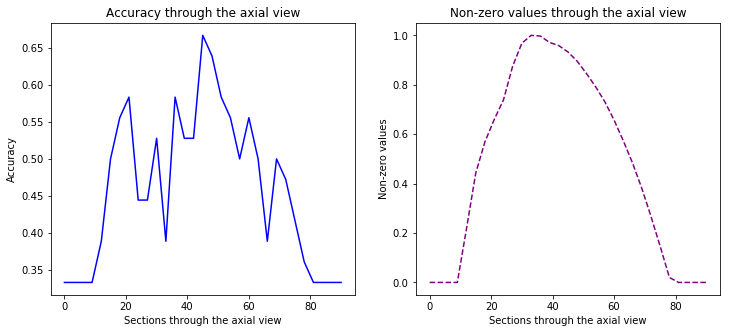

In [40]:
# Display the results as a graph. 
convolutional_neural_network_graph('axial')

### 5.4 Predictions and confusion matrix

In [41]:
# Compute and display the predictions from the sagittal view, by averaging the predictions of all sagittal sections. 
y_pred_sagittal = encoding_order[np.argmax(np.sum(convnet_predictions_sagittal, axis = 0), axis = 1)]
y_pred_sagittal

array(['good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'good', 'good', 'good', 'good', 'bad',
       'bad', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good',
       'good', 'good', 'good', 'bad', 'good'], dtype='<U7')

In [42]:
# Compute and display the test score for the sagittal view. 
test_score_sagittal = np.sum(y_pred_sagittal == y_te) / len(y_te)
test_score_sagittal

0.6388888888888888

In [43]:
# Compute and display the predictions from the coronal view, by averaging the predictions of all coronal sections. 
y_pred_coronal = encoding_order[np.argmax(np.sum(convnet_predictions_coronal, axis = 0), axis = 1)]
y_pred_coronal

array(['good', 'good', 'good', 'good', 'bad', 'bad', 'neutral', 'good',
       'neutral', 'neutral', 'bad', 'bad', 'good', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'good', 'good', 'neutral', 'neutral',
       'bad', 'bad', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'good',
       'good', 'neutral', 'neutral', 'bad', 'good'], dtype='<U7')

In [44]:
# Compute and display the test score for the coronal view. 
test_score_coronal = np.sum(y_pred_coronal == y_te) / len(y_te)
test_score_coronal

0.8055555555555556

In [45]:
# Compute and display the predictions from the axial view, by averaging the predictions of all axial sections. 
y_pred_axial = encoding_order[np.argmax(np.sum(convnet_predictions_axial, axis = 0), axis = 1)]
y_pred_axial

array(['good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good',
       'neutral', 'neutral', 'good', 'good', 'neutral', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'good', 'good', 'neutral', 'neutral',
       'bad', 'bad', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good',
       'good', 'neutral', 'neutral', 'bad', 'bad'], dtype='<U7')

In [46]:
# Compute and display the test score for the axial view. 
test_score_axial = np.sum(y_pred_axial == y_te) / len(y_te)
test_score_axial

0.7777777777777778

In [47]:
# Sum up the predictions of all neurological views. 
convnet_predictions_all_views = np.sum(convnet_predictions_sagittal, axis = 0) + np.sum(convnet_predictions_coronal, axis = 0) + np.sum(convnet_predictions_axial, axis = 0)

# Compute and display the predictions from all neurological views. 
y_pred_convnet = encoding_order[np.argmax(convnet_predictions_all_views, axis = 1)]
y_pred_convnet

array(['good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good',
       'neutral', 'neutral', 'good', 'good', 'good', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'good', 'good', 'good', 'neutral', 'bad',
       'bad', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good', 'good',
       'good', 'good', 'bad', 'good'], dtype='<U7')

In [48]:
# Compute and display the test score for the convolutional neural network.  
test_score_convnet = np.sum(y_pred_convnet == y_te) / len(y_te)
test_score_convnet

0.6944444444444444

In [49]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_convnet = scikit_learn_confusion_matrix(y_te, y_pred_convnet)
confusion_matrix_convnet

Predictions,good,neutral,bad
True class,,,
good,11,0,1
neutral,7,5,0
bad,3,0,9


**Result:** The convolutional neural network models perform better than the baseline of 33% for each neurological view: sagittal, coronal and axial. When we sum up the predictions in order to obtain a global test score, this test score is also higher than the baseline of 33%. As expected, for the peripheral sections where there is little or no information, the convolutional networks perform at the level of chance. 

## **6. Save results**

In [50]:
# Save the results into a .npz file. 
if rescale_mode == 1:
    results_file_name = 'neural_networks_results.npz'
else:
    results_file_name = 'neural_networks_results_r' + str(rescale_mode) + '.npz'

np.savez(results_path + results_file_name, 
         # Test scores. 
         test_score_dense1 = test_score_dense1, 
         test_score_dense2 = test_score_dense2, 
         test_score_convnet = test_score_convnet, 
         
         # Predictions. 
         y_pred_dense1 = y_pred_dense1, 
         y_pred_dense2 = y_pred_dense2, 
         y_pred_convnet = y_pred_convnet)